##  Pocket Fashionista - a Complexion based OutfitColor Advisor using Neural Networks

### Skin segmendation and tone classification

In [ ]:
import cv2
import numpy as np

#Open a simple image
img=cv2.imread("images/male1.jpg")

#converting from gbr to hsv color space
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#skin color range for hsv color space 
HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#converting from gbr to YCbCr color space
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
#skin color range for hsv color space 
YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#merge skin detection (YCbCr and hsv)
global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
global_mask=cv2.medianBlur(global_mask,3)
global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


HSV_result = cv2.bitwise_not(HSV_mask)
YCrCb_result = cv2.bitwise_not(YCrCb_mask)
global_result=cv2.bitwise_not(global_mask)


#show results
#cv2.imshow("1_HSV.jpg",HSV_result)
# cv2.imshow("2_YCbCr.jpg",YCrCb_result)
# cv2.imshow("3_global_result.jpg",global_result)
# cv2.imshow("Image.jpg",img)
cv2.imwrite("1_HSV.jpg",HSV_result)
cv2.imwrite("2_YCbCr.jpg",YCrCb_result)
cv2.imwrite("3_global_result.jpg",global_result)
cv2.waitKey(0)
cv2.destroyAllWindows()  

In [ ]:
pip install imutils

In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt

In [ ]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()

  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  # Defining HSV Threadholds
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
  
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)
  
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

In [ ]:
def removeBlack(estimator_labels, estimator_cluster):
  hasBlack = False
  occurance_counter = Counter(estimator_labels)
  compare = lambda x, y: Counter(x) == Counter(y)
  for x in occurance_counter.most_common(len(estimator_cluster)):
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]
    if compare(color , [0,0,0]) == True:
      del occurance_counter[x[0]]
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break
      
   
  return (occurance_counter,estimator_cluster,hasBlack)

In [ ]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):
  occurance_counter = None
  colorInformation = []
  
  hasBlack =False
  if hasThresholding == True:
    
    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black   
  else:
    occurance_counter = Counter(estimator_labels)
 
  totalOccurance = sum(occurance_counter.values()) 

  for x in occurance_counter.most_common(len(estimator_cluster)):
    index = (int(x[0]))
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index
    color = estimator_cluster[index].tolist()
    color_percentage= (x[1]/totalOccurance)
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }
    colorInformation.append(colorInfo)
  return colorInformation 

In [ ]:
def extractDominantColor(image,number_of_colors=5,hasThresholding=False): 
  if hasThresholding == True:
    number_of_colors +=1
  
  img = image.copy()
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)
  estimator.fit(img)
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation


In [ ]:
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,700,3), dtype="uint8")
  
  top_x = 0
  for x in colorInformation: 
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])
    color = tuple(map(int,(x['color'])))
    cv2.rectangle(color_bar, (int(top_x), 0), (int(bottom_x), color_bar.shape[0]), color, -1)
    top_x = bottom_x
    #break
  return color_bar
#plotColorBar(dominantColors)

In [ ]:
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()
    #break

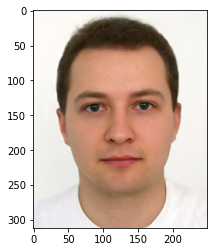

Your Color is 
Fair


In [ ]:
image = cv2.imread('images/male1.jpg')
image = imutils.resize(image,width=250)

plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

skin = extractSkin(image)
#plt.imshow(cv2.cvtColor(skin,cv2.COLOR_BGR2RGB))
#plt.show()
#skin = image
# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors 
dominantColors = extractDominantColor(skin,hasThresholding=True)

color_value=[]
for value in dominantColors:
   color_value.append(value['color'])
  
print("Your Color is ")

if (color_value[0][0] >180 and color_value[0][1] > 130 
    and color_value[0][2] > 100) and (color_value[1][0] >180 and color_value[1][1] > 130 and color_value[1][2] > 100):
    skin_tone = "Fair"
    print("Fair")

elif (color_value[0][0] >160 and color_value[0][1] > 100 
      and color_value[0][2] > 60) and (color_value[1][0] >160 and color_value[1][1] > 100 and color_value[1][2] > 60):
    skin_tone = "Wheatish"
    print("Wheatish")

elif (color_value[0][0] >160 and color_value[0][1] > 80 
      and color_value[0][2] > 40) and (color_value[1][0] >160 and color_value[1][1] > 80 and color_value[1][2] > 40):
    skin_tone = "Medium Brown"
    print("Medium Brown")

elif (color_value[0][0] >130 and color_value[0][1] > 70 
      and color_value[0][2] > 60) and (color_value[1][0] >130 and color_value[1][1] > 70 and color_value[1][2] > 60):
    skin_tone = "Brown"
    print("Brown")

else:
    skin_tone = "Dark Brown"
    print("Dark Brown")


## Outfit colour Recommendation

In [ ]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
os.sys.path
import os.path
import csv
from csv import reader
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import pandas as pd
import urllib
import urllib.request
import urllib.request  as urllib2 
from skimage import io
import random

%matplotlib inline

In [ ]:
formal_shirt = pd.read_csv('men-formal-shirts.csv', index_col = 0)
formal_shirt.head(50)

,NAME,CATEGORY,DESCRIPTION & COLOR,FABRIC,IMAGE,SIZE,PRICE,PRODUCT ID,WEBSITE,PRODUCT URL,COLOUR
SERIAL NO,,,,,,,,,,,
1,Van Heusen Men Green Slim Fit Formal Shirt,formal-shirts,"Van Heusen Men Green Slim Fit Formal Shirt, V...",100% cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,749,7647697,Myntra,https://www.myntra.com/shirts/van-heusen/van-h...,Green
2,Blackberrys Men White & Purple Slim Fit Self-C...,formal-shirts,Blackberrys Men White & Purple Slim Fit Self C...,Cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,1197,7796209,Myntra,https://www.myntra.com/shirts/blackberrys/blac...,Purple
3,INVICTUS Blue Slim Fit Formal Shirt,formal-shirts,"INVICTUS Blue Slim Fit Formal Shirt, INVICTUS...",Cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,719,1295415,Myntra,https://www.myntra.com/shirts/invictus/invictu...,Blue
4,U.S. Polo Assn. Men Pink Regular Fit Striped F...,formal-shirts,U.S. Polo Assn. Men Pink Regular Fit Striped F...,100% cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Regular fit,839,2365066,Myntra,https://www.myntra.com/shirts/us-polo-assn/us-...,Pink
5,Peter England Men Green & Yellow Slim Fit Chec...,formal-shirts,Peter England Men Green & Yellow Slim Fit Chec...,"60%cotton,40%polyester","https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,999,8505391,Myntra,https://www.myntra.com/shirts/peter-england/pe...,Yellow
6,Wills Lifestyle Men Purple Regular Fit Self De...,formal-shirts,Wills Lifestyle Men Purple Regular Fit Self De...,Cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Regular Fit,1119,5504740,Myntra,https://www.myntra.com/shirts/wills-lifestyle/...,Purple
7,Hancock Men Red & White Slim Fit Checked Forma...,formal-shirts,Hancock Men Red & White Slim Fit Checked Forma...,Polycotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,599,2307130,Myntra,https://www.myntra.com/shirts/hancock/hancock-...,Red
8,JAINISH Men Navy Comfort Fit Solid Formal Shirt,formal-shirts,JAINISH Men Navy Comfort Fit Solid Formal Shir...,Cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Comfort fit,439,1490094,Myntra,https://www.myntra.com/shirts/jainish/jainish-...,Navy
9,U.S. Polo Assn. Tailored Men Blue Slim Fit Pri...,formal-shirts,U.S. Polo Assn. Tailored Men Blue Slim Fit Pri...,100% cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,1319,1887342,Myntra,https://www.myntra.com/shirts/us-polo-assn-tai...,Blue


In [ ]:
formal_shirt.shape
#formal_shirt.size
formal_shirt.sample()

,NAME,CATEGORY,DESCRIPTION & COLOR,FABRIC,IMAGE,SIZE,PRICE,PRODUCT ID,WEBSITE,PRODUCT URL,COLOUR
SERIAL NO,,,,,,,,,,,
671,Park Avenue Men Grey Slim Fit Solid Formal Shirt,formal-shirts,Park Avenue Men Grey Slim Fit Solid Formal Shi...,100% cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,759,7652613,Myntra,https://www.myntra.com/shirts/park-avenue/park...,NaN


In [ ]:
def recommend(tone):
    formal_color = formal_shirt['COLOUR']
    #print(formal_color)
    formal_images = formal_shirt['IMAGE']
    ls = list()
    i=0
    count=0
    #dist = list()
    if tone == 'Fair':
        print("Fair")
        for name in formal_color:
            for i in range(1, 90):
                if name=='Green' or name=='Blue' or name=='Black' or name=='Red' or name=='Navy':
                    ls.append(formal_images[i])
                i = i+1
            if(i==90): break;
                    
        dist = random.sample(ls, 9)
#         for l in range(1, 8):
#             j = dist[l]
#             im = io.imread(j)
#             plt.imshow(im)
#             plt.show()  

    elif tone == 'Wheatish':
        print("Wheatish")
        for name in shirt_color:
            for i in range(1, 90):
                if name=='Green' or name=='Yellow' or name=='White' or name=='Purple' or name=='Grey' or name=='Navy' or name=='Lime Green':
                    ls.append(shirt_images[i])
                i = i+1
            if(i==90): break;

        dist = random.sample(ls, 9)
#         for l in range(1, 8):
#             j = dist[l]
#             im = io.imread(j)
#             plt.imshow(im)
#             plt.show()   

    elif tone == 'Medium Brown':
        print("Medium Brown")
        for name in formal_color:
            for i in range(1, 30):
                #print("You choose Weatish!")
                if name=='Light Grey' or name=='Blue' or name=='Lavender' or name=='Green' or name=='Purple' or name=='Cream': 
                    ls.append(formal_images[i])
                i = i+1
            if(i==30): break;
        #print(len(ls))   
        dist = random.sample(ls, 9)
#         for l in range(1, 8):
#             j = dist[l]
#             im = io.imread(j)
#             plt.imshow(im)
#             plt.show() 

    elif tone == 'Brown':
        print("Brown")
        for name in shirt_color:
            for i in range(1, 90):
                if name=='Burgundy' or name=='Dark Grey' or name=='Green' or name=='Maroon' or name=='Navy Blue' or name=='White':
                    ls.append(shirt_images[i])
                i = i+1
            if(i==90): break;

        dist = random.sample(ls, 9)
#         for l in range(1, 8):
#             j = dist[l]
#             im = io.imread(j)
#             plt.imshow(im)
#             plt.show() 

    elif tone == 'Dark Brown':
        print("Dark Brown")
        for name in formal_color:
            for i in range(1, 30):
                #print("You choose Weatish!")
                if name=='White' or name=='Green' or name=='Purple' or name=='Dark Grey' or name=='Mustard' or name=='Coffee Brown' or name=='Charcoal Grey' :
                    ls.append(formal_images[i])
                i = i+1
            if(i==30): break;
            
        dist = random.sample(ls, 9)
#         for l in range(1, 8):
#             j = dist[l]
#             im = io.imread(j)
#             plt.imshow(im)
#             plt.show() 

    else :
        print("Other")
        for name in formal_color:
            for i in range(1, 30):
                #print("You choose Weatish!")
                if name=='Baby Blue' or name=='Green' or name=='Cream' or name=='Sky Blue' or name=='Red White' or name=='Pink' or Name=='Blue': 
                    ls.append(formal_images[i])
                i = i+1
            if(i==30): break;
            
        dist = random.sample(ls, 9)
#         for l in range(1, 8):
#             j = dist[l]
#             im = io.imread(j)
#             plt.imshow(im)
#             plt.show() 
    return dist

In [ ]:
sk_tone = skin_tone
outfit = recommend(sk_tone)
#print(ls)

Fair


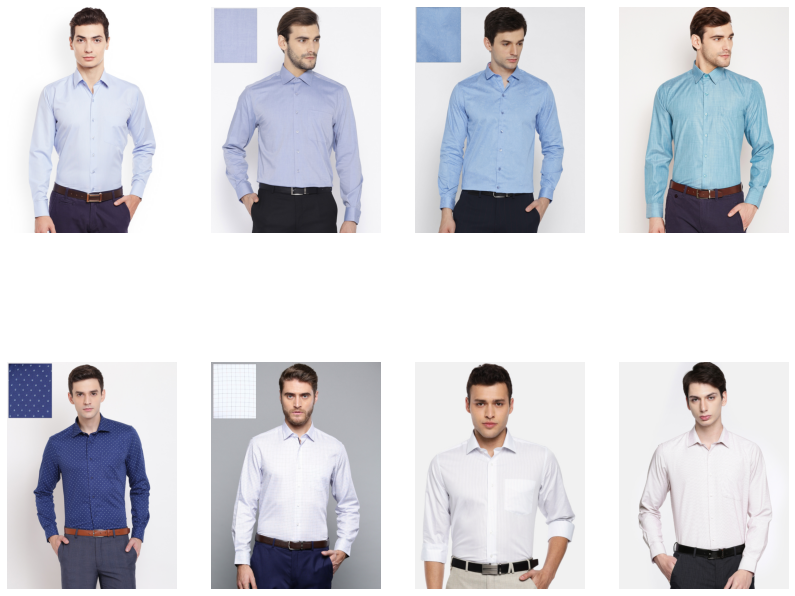

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(14, 12))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    j = outfit[i]
    img = io.imread(j)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

## ---------------*******************************************************************************      ---------------

In [ ]:
def trouserRecommendation(color):
    trouser_color = formal_trouser['COLOR']
    #index = formal_shirt['SERIAL NO']
    formal_images = formal_trouser['IMAGE']
    if color=='Black':
        print("Recommended Trousers will Look better on Black Shirt")
        for name in trouser_color:
            for i in range(1, 20):
                if name=='Black' or name=='Grey' or name=='Beige tapered' or name=='Navy Blue':
                    j = formal_images[i]
                    im = io.imread(j)
                    plt.imshow(im)
                    plt.show()
                i = i+1
            if(i==20): break;
        
        

Fair


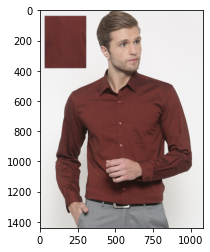

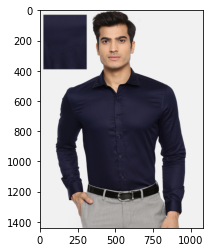

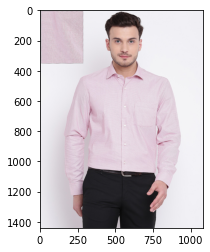

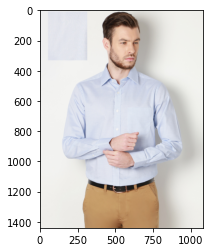

Which color You choose 
Black
Recommended Trousers will Look better on Black Shirt


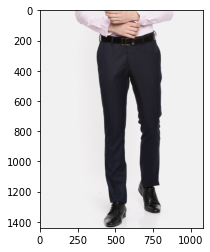

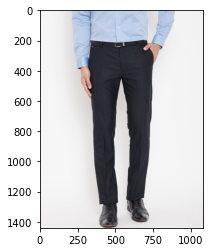

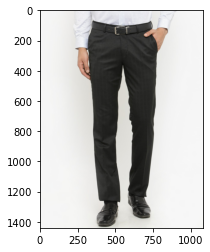

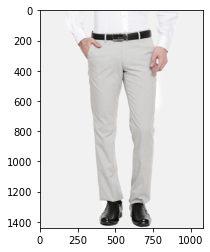

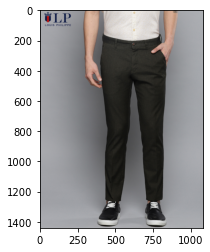

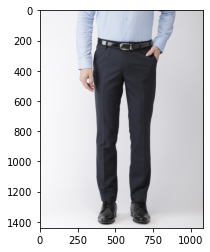

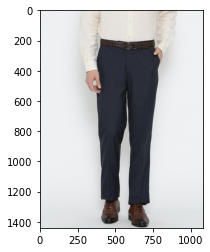

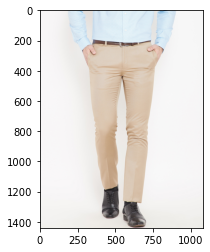

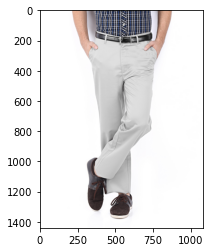

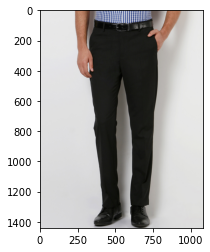

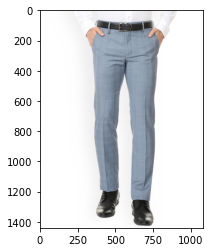

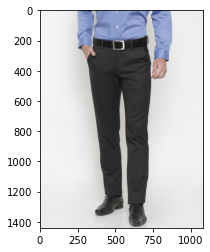

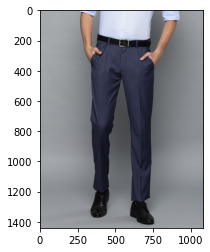

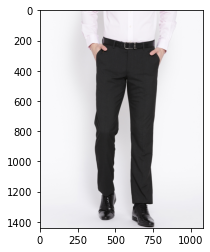

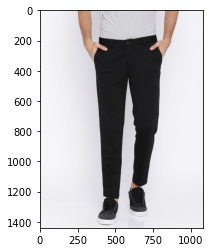

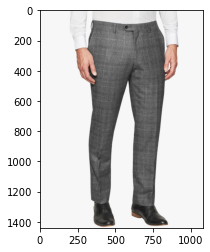

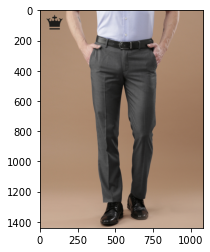

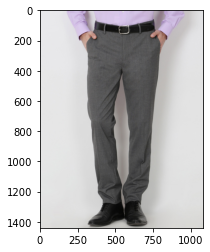

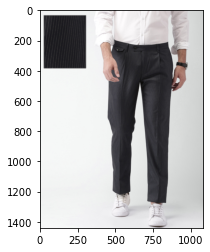

In [ ]:
formal_color = formal_shirt['COLOUR']
#print(formal_color)
formal_images = formal_shirt['IMAGE']
ls = list()
i=0
count=0
print("Fair")
for name in formal_color:
    for i in range(1, 90):
        if name=='Green' or name=='Blue' or name=='Black' or name=='Red' or name=='Navy':
            ls.append(formal_images[i])
        i = i+1
    if(i==90): break;

dist = random.sample(ls, 5)
for l in range(1, 5):
    j = dist[l]
    im = io.imread(j)
    plt.imshow(im)
    plt.show()  

print("Which color You choose ")
trouser = input()
trouserRecommendation(trouser)

In [ ]:
Row info

warm / medium skin tone - brown, green, warm red, mustard yellow, beig, cream, 

cool / fair - blue, purple, green, pastel blue/green/pink/lavendar, 

other / neutral / weatish - dark purple, true red, green, 

dark - navy, white, paler green, 




## Other datasets

In [ ]:
formal_trouser = pd.read_csv('men-formal-trousers.csv', index_col = 0)
formal_trouser.head()

,NAME,CATEGORY,DESCRIPTION & COLOR,FABRIC,IMAGE,SIZE,PRICE,PRODUCT ID,WEBSITE,PRODUCT URL
SERIAL NO,,,,,,,,,,
1,U.S. Polo Assn. Men Navy Blue Slim Fit Solid F...,Men-Formal-Trousers,U.S. Polo Assn. Men Navy Blue Slim Fit Solid F...,"65% polyester, 35% viscose","https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,1199,7148088,Myntra,https://www.myntra.com/trousers/us-polo-assn/u...
2,Blackberrys Men Navy Regular Fit Solid Formal ...,Men-Formal-Trousers,Blackberrys Men Navy Regular Fit Solid Formal ...,"83% polyester, 16% viscose rayon, 1% spandex","https://assets.myntassets.com/h_1440,q_100,w_1...",Regular Fit,1197,8031485,Myntra,https://www.myntra.com/trousers/blackberrys/bl...
3,Wills Lifestyle Men Black Skinny Fit Self-Chec...,Men-Formal-Trousers,Wills Lifestyle Men Black Skinny Fit Self Chec...,Polyester and viscose rayon blend,"https://assets.myntassets.com/h_1440,q_100,w_1...",Skinny Fit,1119,2506751,Myntra,https://www.myntra.com/trousers/wills-lifestyl...
4,Chennis Men Grey Slim Fit Solid Formal Trousers,Men-Formal-Trousers,Chennis Men Grey Slim Fit Solid Formal Trouser...,Polyester,"https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,959,7816751,Myntra,https://www.myntra.com/trousers/chennis/chenni...
5,Louis Philippe Sport Men Olive Green Tapered F...,Men-Formal-Trousers,Louis Philippe Sport Men Olive Green Tapered F...,Cotton and elastane,"https://assets.myntassets.com/h_1440,q_100,w_1...",Tapered Fit,1199,7189641,Myntra,https://www.myntra.com/trousers/louis-philippe...


SERIAL NO
1       https://assets.myntassets.com/h_1440,q_100,w_1...
2       https://assets.myntassets.com/h_1440,q_100,w_1...
3       https://assets.myntassets.com/h_1440,q_100,w_1...
4       https://assets.myntassets.com/h_1440,q_100,w_1...
5       https://assets.myntassets.com/h_1440,q_100,w_1...
                              ...                        
2915    https://assets.myntassets.com/h_1440,q_100,w_1...
2916    https://assets.myntassets.com/h_1440,q_100,w_1...
2917    https://assets.myntassets.com/h_1440,q_100,w_1...
2918    https://assets.myntassets.com/h_1440,q_100,w_1...
2919    https://assets.myntassets.com/h_1440,q_100,w_1...
Name: IMAGE, Length: 2919, dtype: object


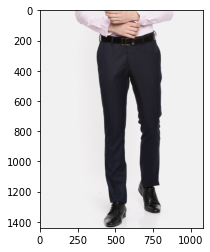

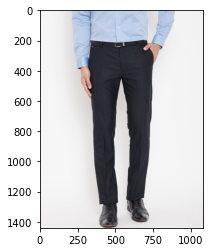

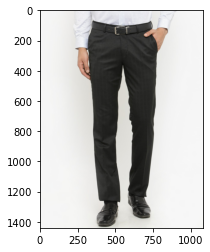

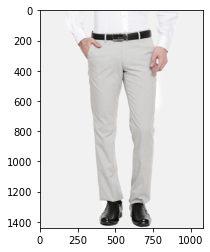

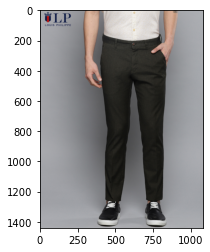

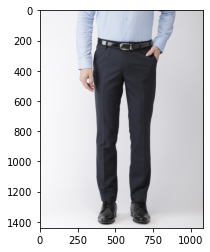

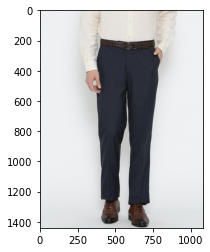

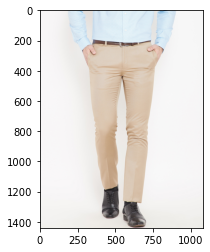

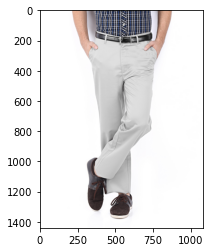

In [ ]:
#trouser_color = formal_trouser['DESCRIPTION & COLOR']
#print(trouser_color)

trouser_images = formal_trouser['IMAGE']
print(trouser_images)
    
i=1
count = 10
for i in range(1, 10):
    j = trouser_images[i]
    im = io.imread(j)
    plt.imshow(im)
    plt.show()
    i = i+1

In [ ]:
suits = pd.read_csv('men-suits.csv', index_col = 0)
suits.head()

In [ ]:
#trouser_color = formal_trouser['DESCRIPTION & COLOR']
#print(trouser_color)

suits_images = suits['IMAGE']
#print(suits_images)
    
i=1
count = 10
for i in range(1, 10):
    j = suits_images[i]
    im = io.imread(j)
    plt.imshow(im)
    plt.show()
    i = i+1

In [ ]:
casuals = pd.read_csv('men-casual-shirts.csv', index_col = 0)
casuals.head()

In [ ]:
#trouser_color = formal_trouser['DESCRIPTION & COLOR']
#print(trouser_color)

casuals_images = casuals['IMAGE']
print(casuals_images)
    
i=1
count = 10
for i in range(1, 10):
    j = casuals_images[i]
    im = io.imread(j)
    plt.imshow(im)
    plt.show()
    i = i+1

In [ ]:
jeans = pd.read_csv('men-jeans.csv', index_col = 0)
jeans.head()

In [ ]:
#trouser_color = formal_trouser['DESCRIPTION & COLOR']
#print(trouser_color)

jeans_images = jeans['IMAGE']
print(jeans_images)
    
i=1
count = 10
for i in range(1, 10):
    j = jeans_images[i]
    im = io.imread(j)
    plt.imshow(im)
    plt.show()
    i = i+1

In [ ]:
jeans_color = jeans['DESCRIPTION & COLOR']
print(jeans_color)

In [ ]:
formal_trouser = pd.read_csv('men-formal-trousers.csv', index_col = 0)
#formal_trouser.head()

trouser_color = formal_trouser['DESCRIPTION & COLOR']
#index = formal_shirt['SERIAL NO']
formal_images = formal_trouser['IMAGE']
formal_trouser.head(5)
# for i in range(1,20):
#     print(i)
#     print(trouser_color[i])
#     j = formal_images[i]
#     im = io.imread(j)
#     plt.imshow(im)
#     plt.show()

,NAME,CATEGORY,DESCRIPTION & COLOR,FABRIC,IMAGE,SIZE,PRICE,PRODUCT ID,WEBSITE,PRODUCT URL,COLOR
SERIAL NO,,,,,,,,,,,
1,U.S. Polo Assn. Men Navy Blue Slim Fit Solid F...,Men-Formal-Trousers,U.S. Polo Assn. Men Navy Blue Slim Fit Solid F...,"65% polyester, 35% viscose","https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,1199,7148088,Myntra,https://www.myntra.com/trousers/us-polo-assn/u...,Navy Blue
2,Blackberrys Men Navy Regular Fit Solid Formal ...,Men-Formal-Trousers,Blackberrys Men Navy Regular Fit Solid Formal ...,"83% polyester, 16% viscose rayon, 1% spandex","https://assets.myntassets.com/h_1440,q_100,w_1...",Regular Fit,1197,8031485,Myntra,https://www.myntra.com/trousers/blackberrys/bl...,Navy
3,Wills Lifestyle Men Black Skinny Fit Self-Chec...,Men-Formal-Trousers,Wills Lifestyle Men Black Skinny Fit Self Chec...,Polyester and viscose rayon blend,"https://assets.myntassets.com/h_1440,q_100,w_1...",Skinny Fit,1119,2506751,Myntra,https://www.myntra.com/trousers/wills-lifestyl...,Black
4,Chennis Men Grey Slim Fit Solid Formal Trousers,Men-Formal-Trousers,Chennis Men Grey Slim Fit Solid Formal Trouser...,Polyester,"https://assets.myntassets.com/h_1440,q_100,w_1...",Slim fit,959,7816751,Myntra,https://www.myntra.com/trousers/chennis/chenni...,Grey
5,Louis Philippe Sport Men Olive Green Tapered F...,Men-Formal-Trousers,Louis Philippe Sport Men Olive Green Tapered F...,Cotton and elastane,"https://assets.myntassets.com/h_1440,q_100,w_1...",Tapered Fit,1199,7189641,Myntra,https://www.myntra.com/trousers/louis-philippe...,Olive Green
